In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from builtins import round

from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder, QuantileTransformer, Binarizer, KBinsDiscretizer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, classification_report, make_scorer, precision_score, recall_score
from sklearn.feature_selection import SelectFromModel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

%config InlineBackend.figure_format = 'retina'

# __Name__

### Zachary Dougherty

# __Research Question__

### Can we predict employee attrition (when employees leave the company)? 

# __Load the Data__

In [2]:
types = {
    'Age':'Int64',
    'BusinessTravel':'category',
    'DailyRate':'Int64',
    'Department':'category',
    'DistanceFromHome':'Int64',
    'Education':'category',
    'EducationField':'category',
    'EnvironmentSatisfaction':'category',
    'Gender':'category',
    'HourlyRate':'Int64',
    'JobInvolvement':'category',
    'JobLevel':'category',
    'JobRole':'category',
    'JobSatisfaction':'category',
    'MaritalStatus':'category',
    'MonthlyIncome':'Int64',
    'MonthlyRate':'Int64',
    'NumCompaniesWorked':'Int64',
    'OverTime':'category',
    'PercentSalaryHike':'Int64',
    'PerformanceRating':'category',
    'RelationshipSatisfaction':'category',
    'StockOptionLevel':'category',
    'TotalWorkingYears':'Int64',
    'TrainingTimesLastYear':'category',
    'WorkLifeBalance':'Int64',
    'YearsAtCompany':'Int64',
    'YearsInCurrentRole':'Int64',
    'YearsSinceLastPromotion':'Int64',
    'YearsWithCurrManager':'Int64',
    'Attrition':'category'
}

In [3]:
# load the data
attrition = pd.read_csv('https://raw.githubusercontent.com/ZachDougherty/msds699-final/master/data/attrition_train.csv', dtype=types)
attrition.sample(5)

,Unnamed: 0,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
636,252,29,Travel_Rarely,665,Research & Development,15,3,Life Sciences,3,Male,60,3,1,Research Scientist,4,Single,2340,22673,1,No,19,3,1,0,6,1,3,6,5,1,5,No
1015,667,41,Travel_Rarely,1085,Research & Development,2,4,Life Sciences,2,Female,57,1,1,Laboratory Technician,4,Divorced,2778,17725,4,Yes,13,3,3,1,10,1,2,7,7,1,0,Yes
1061,414,24,Travel_Rarely,1448,Sales,1,1,Technical Degree,1,Female,62,3,1,Sales Representative,2,Single,3202,21972,1,Yes,16,3,2,0,6,4,3,5,3,1,4,Yes
396,1073,28,Travel_Rarely,1083,Research & Development,29,1,Life Sciences,3,Male,96,1,2,Manufacturing Director,2,Married,6549,3173,1,No,14,3,2,2,8,2,2,8,6,1,7,No
1125,1025,24,Travel_Rarely,1476,Sales,4,1,Medical,4,Female,42,3,2,Sales Executive,3,Married,4162,15211,1,Yes,12,3,3,2,5,3,3,5,4,0,3,No


In [5]:
# get X and y, drop the extra column and target column
y = attrition.Attrition.values
X = attrition.drop(['Attrition','Unnamed: 0'], axis=1)

In [6]:
# fix y, 1 = 'Yes', 0 = 'No'
y = LabelEncoder().fit_transform(y)

In [7]:
# class imbalance
print('Train',pd.Series(y).value_counts() / y.shape[0], sep='\n'); print()

Train
0    0.840136
1    0.159864
dtype: float64



# __Baseline__

We are going to train some models to get a baseline performance so we can evaluate the success or failuer of our feature engineering. Since we want to find all employees who may want to leave the company, we want to optimize for the True Negative Rate or specificity. Since sklearn doesn't have specifity as a default metric, we will create it here.

In [8]:
# defining the specificity metric
def specificity(y_true, y_pred):
    TN = np.sum(y_pred[y_true == 0] == 0) # find all correctly predicted neg values
    FP = np.sum(y_pred[y_true == 0] == 1) # find all falsely predicted pos values
    return TN / (TN + FP)

specificity_score = make_scorer(specificity)

In [9]:
# get the cols of different types for our transformers
cat_cols = np.where(X.dtypes == "category")[0]
num_cols = np.where(X.dtypes == "Int64")[0]

In [10]:
# Need to OHE for LogisticRegression 
tree_ct = ColumnTransformer([
    ('ord_enc', OrdinalEncoder(), cat_cols),
    ('sc', StandardScaler(), num_cols)
])

linear_ct = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat_cols),
    ('sc', StandardScaler(), num_cols)
])

In [11]:
# baseline models on raw dataset
models = [
    RidgeClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    SGDClassifier,
    GradientBoostingClassifier,
    SVC
]

# class imbalance from observed values
params = {
    'class_weight': {0:0.15, 1:0.85}
}

specs = []
recalls = []
precisions = []
for model in models:
    if model == LogisticRegression or model == SGDClassifier or model == RidgeClassifier:
        pipe = Pipeline([
            ('pre', linear_ct),
            ('model', model(**params))
        ])
    elif model == GradientBoostingClassifier:
        pipe = Pipeline([
            ('pre', linear_ct),
            ('model', model())
        ])
    else:
        pipe = Pipeline([
            ('pre', tree_ct),
            ('model', model(**params))
        ])
    
    pipe.fit(X, y)
    spec = np.mean(cross_val_score(pipe, X, y, scoring=specificity_score, cv=5))
    recall = np.mean(cross_val_score(pipe, X, y, scoring=make_scorer(recall_score), cv=5))
    precision = np.mean(cross_val_score(pipe, X, y, scoring=make_scorer(precision_score), cv=5))
    
    specs.append(spec)
    recalls.append(recall)
    precisions.append(precision)
    
baselines = pd.DataFrame({
    "Models": [str(m()) for m in models],
    "Specificity": specs,
    "Recall": recalls,
    "Precision": precisions
})
baselines.sort_values("Recall", ascending=False)

,Models,Specificity,Recall,Precision
0,RidgeClassifier(),0.768266,0.771266,0.391600
1,LogisticRegression(),0.776368,0.749644,0.393597
7,SVC(),0.693339,0.738549,0.313975
5,SGDClassifier(),0.800723,0.728592,0.331333
2,DecisionTreeClassifier(),0.864390,0.319061,0.301613
6,GradientBoostingClassifier(),0.971681,0.249502,0.632178
4,ExtraTreesClassifier(),0.990899,0.143101,0.671429
3,RandomForestClassifier(),0.992929,0.079659,0.720000


Our goal is to optimize for high Recall, because it is better to check in on an employee who has no desire to leave rather than to forget about employees who are very likey to leave, so we would rather over predict attrition than underpredict. Ideally, we want to have a high Recall score and fairly high Specificity. Performing well according to both of these metrics tells us that our model is fairly good at separating the two classes of employees, those that will likely leave a company and those who are likely to stay. The best candidate models with these given goals are the linear models, namely LogisticRegression (higher Specificity) and Ridge Logistic Regression (higher Recall). We will continue our model development with these candidate models and SGDClassifier in mind.

### __Candidate Models__
- RidgeClassifier
- LogisticRegression
- SGDClassifier

# __Model Development__

### __Feature Engineering for Linear Models__

__1) Normality:__ Linear models expect approximately normal columns, so we will transform some skewed numeric columns into normally distributed columns:
- __DailyRate__: Uniform
- __HourlyRate__: Very strange distribution, close to uniform
- __MonthlyIncome__: Skewed right
- __MonthlyRate__: Uniform
- __TotalWorkingYears__: Skewed right

In [12]:
to_norm_cols = np.where((X.columns == "MonthlyIncome") | (X.columns == "MonthlyRate") | (X.columns == "TotalWorkingYears") | (X.columns == "DailyRate") |
                        (X.columns == "HourlyRate"))[0]

to_norm_ct = ("norm_qt", QuantileTransformer(output_distribution="normal"), list(to_norm_cols))

__2) Discretization:__ Though we have many numeric columns, they are pseudo-categorical, as they only contain integer values and have small ranges. There a few ways to deal with this problem, one we will try is discretizing these numeric columns into sub-groups. For instance, in the DistanceFromHome column, we can observe a large drop off in the frequency of values after about 2 and 10 miles, with approximately uniform distributions before and after these threshold values, so we can create 3 new categories, "close to home", "moderate distance", "far from home". We can choose to either encode new categories, or simply break up the values into an arbitrary number of bins. This has the simultaneous effects of reducing complexity in the model, reducing feature space, and extracting some real world meaning from the variable distributions. For these purposes, we will use the sklearn provided __Binarizer__ and __KBinsDiscretizer__ classes. Using KBinsDiscretizer, we can use "quantile" as our method so that each category will have approximately the same number of observations, creatin approximately the desired categories for columns like "DistanceFromHome". Here are descriptions for the columns I adjusted:
- __DistanceFromHome__: As mentioned, we are splitting up this column into 3, equally distributed bins.
- __NumCompaniesWorked__: Split up into people who have remained relatively stable and people who have moved to many different companies.
- __PercentSalaryHike__: There is a large drop off in frequency after 15%, with a steady decline after that. We will use 3 quantile bins
- __YearsAtCompany__: Most people have been at a given company for 10 years or less, so let's try a Binarizer for this threshold.
- __YearsSinceLastPromotion__: The frequency drops off significantly after 2 years, so we will try a Binarizer to represent people who have been recently promoted and those who have worked a long time without one.
- __YearsInCurrentRole and YearsWithCurrManager__: These two columns are almost identical in distribution and scale, so we don't really need both of them. We will discretize them differently to try and avoid multicollinearity.

In [13]:
# getting our distance bins as mentioned
distance_bins = ("dist_bins", KBinsDiscretizer(n_bins=3, strategy="quantile", encode="onehot"), list(np.where(X.columns == "DistanceFromHome")[0]))

# NumCompanies
numcomp_binzer = ("numcomp_binzer", Binarizer(threshold=1), list(np.where(X.columns == "NumCompaniesWorked")[0]))

# PercentSalaryHike
pctsal_bins = ("pctsal_bins", KBinsDiscretizer(n_bins=3, strategy="quantile", encode="onehot"), list(np.where(X.columns == "PercentSalaryHike")[0]))

# YearsAtCompany
yrs_binzer = ("yrs_binzer", Binarizer(threshold=10), list(np.where(X.columns == "YearsAtCompany")[0]))

# YearsSinceLastPromotion
promo_binzer = ("promo_binzer", Binarizer(threshold=2), list(np.where(X.columns == "YearsSinceLastPromotion")[0]))

# YearsInCurrentRole
curr_role_bins = ("curr_role_bins", KBinsDiscretizer(n_bins=4, strategy="quantile", encode="onehot"), list(np.where(X.columns == "YearsInCurrentRole")[0]))

# YearsWithCurrManager
curr_man_bins = ("curr_man_bins", KBinsDiscretizer(n_bins=5, strategy="uniform", encode="onehot"), list(np.where(X.columns == "YearsWithCurrManager")[0]))

Putting it all together, we will construct a ColumnTransformer to alter our current set of columns. This will be used as a first step in our pipeline and the output will be fed to our "standard" column transformer.

In [14]:
norm_quant_bin_ct = ColumnTransformer([
    to_norm_ct, distance_bins, numcomp_binzer, pctsal_bins, yrs_binzer, promo_binzer, curr_role_bins, curr_man_bins
], remainder="passthrough")

We need to adjust the columns used for our standard transformers since we have changed the data types of some of our columns and the ColumnTransformer doesn't retain the order of the original columns. Since some columns are of type "category", we need to convert them to numeric type. This can be accomplished by either casting the type of the column or using an OridnalEncoder(), we will choose OrdinalEncoder to remain consistent with scikit-learn's API.

In [17]:
new_ohe_cols = [24, 25, 27, 29, 32, 34, 35, 36]
ordinal_cols = [26, 28, 30, 31, 33, 37, 38, 39, 40]
new_sc_cols  = [23]

In [18]:
linear_ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), new_ohe_cols),
    ('ord_enc', OrdinalEncoder(), ordinal_cols),
    ('sc', StandardScaler(), new_sc_cols)
], remainder="passthrough")

In [19]:
params = {
    'class_weight': {1:0.85, 0:0.15}
}

models = [LogisticRegression, RidgeClassifier, SGDClassifier]
specs = []
recalls = []
precisions = []
for model in models:
    if model == LogisticRegression:
        params.update({"solver":"liblinear"})
    pipe = Pipeline([
                ('feat_eng', norm_quant_bin_ct),
                ('pre', linear_ct),
                ('model', model(**params))
            ])
    if model == LogisticRegression:
        del params["solver"]
    
    pipe.fit(X, y)

    specs.append(np.mean(cross_val_score(pipe, X, y, scoring=specificity_score, cv=5)))
    recalls.append(np.mean(cross_val_score(pipe, X, y, scoring=make_scorer(recall_score), cv=5)))
    precisions.append(np.mean(cross_val_score(pipe, X, y, scoring=make_scorer(precision_score), cv=5)))
    
baselines = pd.DataFrame({
    "Models": [str(m()) for m in models],
    "Specificity": specs,
    "Recall": recalls,
    "Precision": precisions
})
baselines.sort_values("Recall", ascending=False)

,Models,Specificity,Recall,Precision
2,SGDClassifier(),0.682346,0.727027,0.264990
1,RidgeClassifier(),0.755104,0.717496,0.359414
0,LogisticRegression(),0.762201,0.717212,0.368619


So, most of these changes seem to have decreased model performance. We will try again, this time we will force all numeric columns to be normally distributed, and not binarize or discretize columns.

### __Feature Engineering for Linear Models Take 2__

__1) Normality:__ Let's just convert all numeric columns into normal columns
- __DailyRate__: Uniform
- __DistancFromHome__: Skewed right
- __PercentSalaryHike__: Skewed right
- __HourlyRate__: Very strange distribution, close to uniform
- __MonthlyIncome__: Skewed right
- __MonthlyRate__: Uniform
- __TotalWorkingYears__: Skewed right
- __YearsAtCompany__: Skewed right
- __YearsInCurrentRole__: Strange distribution
- __YearsSinceLastPromotion__: Right skewed
- __YearsWithCurrManager__: Similar to YearsInCurrentRole

In [20]:
cols_df = pd.DataFrame({"cols":X.columns, "idx": np.arange(X.shape[1])}).set_index("cols")
to_norm_cols = cols_df.loc[["DailyRate","DistanceFromHome","PercentSalaryHike","HourlyRate",
                           "MonthlyIncome","MonthlyRate","TotalWorkingYears","YearsAtCompany",
                           "YearsInCurrentRole","YearsSinceLastPromotion","YearsWithCurrManager"],
                           "idx"].values


to_norm_ct = ColumnTransformer([("norm_qt", QuantileTransformer(output_distribution="normal"), list(to_norm_cols))], remainder="passthrough")

__2) Categorical Encoding:__ Now we need to encode the rest of the columns, either One Hot Encoding for columns without a proper ordering, such as JobRole, or Ordinal Encoding for columns such as EducationLevel.

In [21]:
new_ohe_cols = [12, 13, 15, 17, 20, 22, 24, 25, 26, 27]
ordinal_cols = [14, 16, 18, 19, 21, 23, 28, 29]
new_sc_cols  = [11]

In [22]:
linear_ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), new_ohe_cols),
    ('ord_enc', OrdinalEncoder(), ordinal_cols),
    ('sc', StandardScaler(), new_sc_cols)
], remainder="passthrough")

In [23]:
params = {
    'class_weight': {1:0.85, 0:0.15}
}

models = [LogisticRegression, RidgeClassifier, SGDClassifier]
specs = []
recalls = []
precisions = []
for model in models:
    if model == LogisticRegression:
        params.update({"solver":"liblinear"})
    pipe = Pipeline([
                ('feat_eng', to_norm_ct),
                ('pre', linear_ct),
                ('model', model(**params))
            ])
    if model == LogisticRegression:
        del params["solver"]
    
    pipe.fit(X, y)
    
    specs.append(np.mean(cross_val_score(pipe, X, y, scoring=specificity_score, cv=5)))
    recalls.append(np.mean(cross_val_score(pipe, X, y, scoring=make_scorer(recall_score), cv=5)))
    precisions.append(np.mean(cross_val_score(pipe, X, y, scoring=make_scorer(precision_score), cv=5)))
    
baselines = pd.DataFrame({
    "Models": [str(m()) for m in models],
    "Specificity": specs,
    "Recall": recalls,
    "Precision": precisions
})
baselines.sort_values("Recall", ascending=False)

,Models,Specificity,Recall,Precision
2,SGDClassifier(),0.771148,0.781792,0.409331
1,RidgeClassifier(),0.752100,0.744523,0.367917
0,LogisticRegression(),0.761175,0.733713,0.369905


### __Feature Engineering Conclusion__
After many different attempts at feature engineering, I was not able to get better results from altering the distribution of columns or discretizing pseudo-numeric columns. This may be because in the process of discretization, we lose information about the columns. It seems that for this dataset, reducing the feature space did not improve performance, so for our hyperparameter tuning, we will carry on with a LogisticRegression model trained on one hot encoded categorical columns and z-normalized numeric columns.

# __Hyperparameter Tuning__

In [24]:
cat_cols = np.where(X.dtypes == "category")[0]
num_cols = np.where(X.dtypes == "Int64")[0]

In [27]:
linear_ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ('sc', StandardScaler(), num_cols)
])

In [30]:
model = Pipeline([
    ('pre', linear_ct),
    ('clf', RidgeClassifier())
])


params = {
    "clf__alpha": [0.001,0.01,0.01,1,10,100],
    "clf__class_weight": [{1:wgt, 0:1-wgt} for wgt in np.linspace(0.7, 0.9, 20)],
    "clf__solver": ["auto","svd","lsqr","sage"]
}

cv = RandomizedSearchCV(estimator=model,
                        param_distributions=params,
                        n_iter=30,
                        cv=5,
                        scoring=make_scorer(recall_score),
                        n_jobs=-1,
                        )

cv.fit(X, y)
cv.best_score_

0.8247510668563299

In [31]:
cv.best_estimator_['clf']

RidgeClassifier(alpha=10,
                class_weight={0: 0.1105263157894737, 1: 0.8894736842105263},
                solver='lsqr')

To choose the best class weights, we will take a look at how recall and precision change as we adjust the weights.

In [32]:
recalls = []
precisions = []
specs = []
for i in np.linspace(0.5, 0.99, 100):
    final_model = Pipeline([
        ('pre', linear_ct),
        ('clf', RidgeClassifier(
            alpha=10,
            solver='lsqr',
            class_weight={1:i, 0:1-i}
        ))
    ])
    
    pipe.fit(X, y)
    recalls.append(np.mean(cross_val_score(final_model, X, y, scoring=make_scorer(recall_score), cv=5)))
    precisions.append(np.mean(cross_val_score(final_model, X, y, scoring=make_scorer(precision_score), cv=5)))
    specs.append(np.mean(cross_val_score(final_model, X, y, scoring=specificity_score, cv=5)))

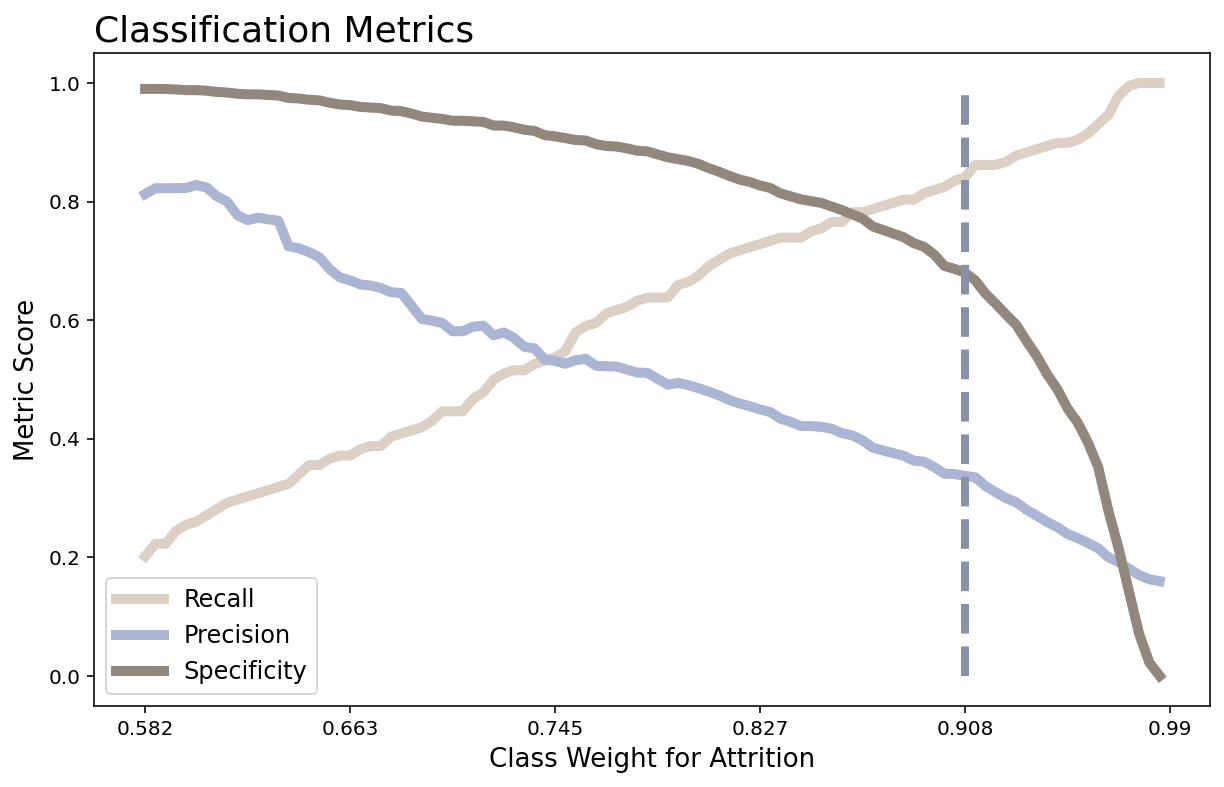

In [33]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(recalls, label="Recall", c="#dcd0c5", lw=5)
ax.plot(precisions, label="Precision", c="#abb6d4",lw=5)
ax.plot(specs, label="Specificity", c="#91877d", lw=5)
labs = [round(val, 3) for val in np.linspace(0.5, 0.99, 7)]
ax.plot([80,80], [0,1], '--', c="#8891a9", lw=4)
ax.set_xlabel("Class Weight for Attrition", fontsize=13)
ax.set_ylabel("Metric Score", fontsize=13)
ax.set_xticklabels(labs)
ax.set_title("Classification Metrics", fontsize=18, loc='left')

ax.legend(fontsize="large")
plt.show()

Based off of this plot, I will weight the minority class (attrition) with 0.90 and the majority class with 0.1. This will give high recall while still maintaing fairly high specificity. While Precision will be very low for our model, it isn't a big problem because as previously mentioned, a company trying to find out what type of employee could be at risk would rather provide support to more employees, even if some may not need it, rather than miss some employees who definitely need it. 

### __Final Model__

In [34]:
model = Pipeline([
    ('pre', linear_ct),
    ('clf', RidgeClassifier(
        alpha=10,
        solver="svd",
        class_weight={1:0.9, 0:0.1}
    ))
])

# __Model Evaluation__

In [35]:
# prepare test data
test = pd.read_csv('https://raw.githubusercontent.com/ZachDougherty/msds699-final/master/data/attrition_test.csv', dtype=types)

In [36]:
y_test = test.Attrition.values
X_test = test.drop(['Attrition','Unnamed: 0'], axis=1)

In [37]:
# fix y, 1 = 'Yes', 0 = 'No'
y_test = LabelEncoder().fit_transform(y_test)

In [38]:
model.fit(X, y)
pred = model.predict(X)
pred = model.predict(X_test)
recall_score(y_test, pred), precision_score(y_test, pred), specificity(y_test, pred)

(0.8367346938775511, 0.3153846153846154, 0.636734693877551)

In [39]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.95      0.64      0.76       245
           1       0.32      0.84      0.46        49

    accuracy                           0.67       294
   macro avg       0.63      0.74      0.61       294
weighted avg       0.85      0.67      0.71       294



# __Feature Importance__

Since StandardScaler doesn't let us get the feature names, so we need to remove that part of the transformer so we can understand feature importance.

In [40]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), cat_cols)
], remainder="passthrough")

ct.fit(X, y)
features = ct.get_feature_names()
feat_imps = zip(features, model['clf'].coef_[0])
print("Feature\t\t\t ", "Coefficient")
for feat, imp in sorted(feat_imps, key=lambda x: np.abs(x[1]), reverse=True)[:10]:
    print(f"{feat:<30}", f"{imp:.3f}", sep='\t')

Feature			  Coefficient
ohe__x11_No                   	-0.256
ohe__x11_Yes                  	0.256
ohe__x7_2                     	-0.229
YearsAtCompany                	0.214
ohe__x6_1                     	0.211
ohe__x0_Non-Travel            	-0.201
YearsWithCurrManager          	-0.192
ohe__x0_Travel_Frequently     	0.192
ohe__x8_Research Scientist    	-0.192
ohe__x4_1                     	0.191


In [41]:
X.columns[cat_cols][[11, 7, 6, 0, 8, 4]].values

array(['OverTime', 'JobLevel', 'JobInvolvement', 'BusinessTravel',
       'JobRole', 'EnvironmentSatisfaction'], dtype=object)

So according to this model, the largest contributing factor to employee attrition is whether or not they work overtime. We can see coefficients of opposite signs but similar magnitude for the presence or absence of overtime in an employees schedule.